# TOF Sensor Data Analysis - Basic Tests

## Objective

The objective of this notebook is to analyze the effectiveness of WaveShare's Time of Flight (TOF) sensor at measuring distance, and draw conclusions from the data measured.

## Overview

I conducted 3 tiers of testing and data collection:

1. **Basic Tests**: The goal of this level of testing was to determine the accuracy of the TOF sensor in a controlled environment.
2. **Simple Outdoors Tests**: After setting up the sensor on a bicycle, the next level of testing involved riding past stationary objects and determining the accuracy of the data collected, and how effective the sensor was as a binary object detector.
3. **Cycling Tests**: The final level of testing involved using the sensor to measure the distances of cars overtaking the cyclist. The goal of this project is to ultimately collect data on this subject.

In [14]:
import datetime
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from data_loader import get_data_from_txt, get_data_from_xlsx, get_data_from_folder
from preprocessing import get_mean_measurements, get_standard_deviations, clean_array, clean_tof_raw_data

## Basic Tests

* The first object is to determine the distance measuring capabilities of the TOF Sensor.
* I placed the sensor at intervals of 0.5 meters, from 0.5 meters to 5.0 meters, and allowed it to measure the distance for 500 points using the Windows software provided by WaveShare.
* I then take the average of the distances measured at each interval, and compare it to the **acutal** distance.

### WaveShare Documentation

* WaveShare's [documentation](https://www.waveshare.com/wiki/TOF_Laser_Range_Sensor#Specification) states that the accuracy of the TOF sensor would be affected by natural light.
* Furthermore, it gave an estimate of the accuracy and standard deviation depending on the distances measured:

||Short Range (0 to 2.16m)|Mid Range (2.16 to 3.60 m)|Long Range (> 3.60m)|
|---|---|---|---|
|Accuracy|±1.0cm|±1.0cm|±1.5cm|
|Standard Deviation|0.3cm|1.5cm|8cm|

### Setup

- After collecting the dat via the software from WaveShare, I extract the data collected at each interval into a separate excel file. The files can be found in [here](./data/basic_tests/).
- I label each files based on their respective distance interval. For example, at 1.5m, the file is labeled "TOF 1-5".
- Below, I define some constants and helper functions for extracting the data from the files.

#### Testing with a Shade

- To reduce the sensor's exposure to sunlight and by extension to improve its accuracy and precision, I 3D-printed a casing that would function as a shade.
- I will be including a comparison between the indoors and outdoors data, and the data collected using a shade in the outdoors.
- I collected the data with the 3D case using the Raspberry Pi instead of the default software provided. One key difference in the data collected is that the distance will be logged as -1 if the signal strength of the sensor is equal to 0. So instead of giving an extremely inaccurate prediction, the sensor will record the distance measured as -1.
- Because of this, I have to do a bit of data preprocessing:
  - First, I extract only the distances from the data collected.
  - I then remove all the -1 measurements indicating a null measurement.
  - Finally, I convert all the distances to meters from millimeters.

In [15]:
ACTUAL_DISTANCES = [0.5 * i for i in range(1, 11)]
OUTDOORS_DATA_PATH = pathlib.Path("./data/basic_tests/outdoors")
INDOORS_DATA_PATH = pathlib.Path("./data/basic_tests/indoors")
WITH_SHADE_DATA_PATH = pathlib.Path("./data/basic_tests/with_shade/")

outdoors_raw_data = get_data_from_folder(OUTDOORS_DATA_PATH, get_data_from_xlsx)
indoors_raw_data = get_data_from_folder(INDOORS_DATA_PATH, get_data_from_xlsx)

with_shade_raw_data = get_data_from_folder(WITH_SHADE_DATA_PATH, get_data_from_txt)
with_shade_raw_data = [distance_interval[1] for distance_interval in with_shade_raw_data]
with_shade_raw_data = [[round(distance / 1000, 2) for distance in distance_interval if distance != -1] for distance_interval in with_shade_raw_data]

### Accuracy

- We evaluate the sensor's accuracy by plotting the mean measured distance at each interval against the actual distance being measured.
- First, I create a table comparing the average measurement at each distance interval compared to the actual distances.

In [16]:
outdoors_mean = get_mean_measurements(outdoors_raw_data)
indoors_mean = get_mean_measurements(indoors_raw_data)
with_shade_mean = get_mean_measurements(with_shade_raw_data)

data = {
    "Actual Distance": ACTUAL_DISTANCES,
    "Outdoors Mean": outdoors_mean,
    "Indoors Mean": indoors_mean,
    "With Shade Mean": with_shade_mean
}
df = pd.DataFrame(data)
display(df.T)

,0,1,2,3,4,5,6,7,8,9
Actual Distance,0.50,1.0,1.50,2.00,2.50,3.00,3.50,4.00,4.50,5.00
Outdoors Mean,0.50,1.0,1.54,2.11,2.60,2.96,3.28,3.33,3.32,2.96
Indoors Mean,0.52,1.0,1.50,2.02,2.50,3.02,3.52,4.04,4.35,4.06
With Shade Mean,0.50,1.0,1.50,1.96,2.38,2.83,3.06,2.49,2.75,1.70


- Next I plot the graphs, where we can see that the sensor performs far better under indoor conditions where it is not exposed to natural light.
- In the outdoors graph, the sensor gives accurate results until around 3.0m where it seems unable to measure any further. However, in the indoors graph, the sensor measures the actual distance almost perfectly up until 4.0m.
- It is also interesting to see in both graphs that the average measured distances dip at 5.0m. It is possible that this is because of the huge amount of spurious data produced by the sensor as it gets more inaccurate, leading to a lower average.
- Interestingly, we also see that the sensor performs far worse with the shade in outdoors conditions. I suspect that this is because at further distances, like 3.0 meters onwards, the shade actually impedes with the sensor's ability to collect data. I realized that a slight tilt in the angle of the sensor will see the shade interferring with the measurement of the sensor.

In [17]:
def plot_mean_vs_actual_distance(ax: mpl.axes.Axes, data: list[float], title="") -> None:
    """
    Plot the measured mean against the actual distance.

    Args:
        ax (mpl.axes.Axes): Matplotlib axes object.
        data (list[float]): data[i] is the mean of the points measured at interval i.
        title (str): Title of the graph
    """
    ax.plot(ACTUAL_DISTANCES, data)
    ax.plot(ACTUAL_DISTANCES, ACTUAL_DISTANCES, color="red", linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("Actual Distance (m)")
    ax.set_ylabel("Measured Mean (m)")
    ax.set_xticks(ACTUAL_DISTANCES)
    ax.set_yticks(ACTUAL_DISTANCES)
    ax.legend(["TOF Sensor", "Actual Distance"])

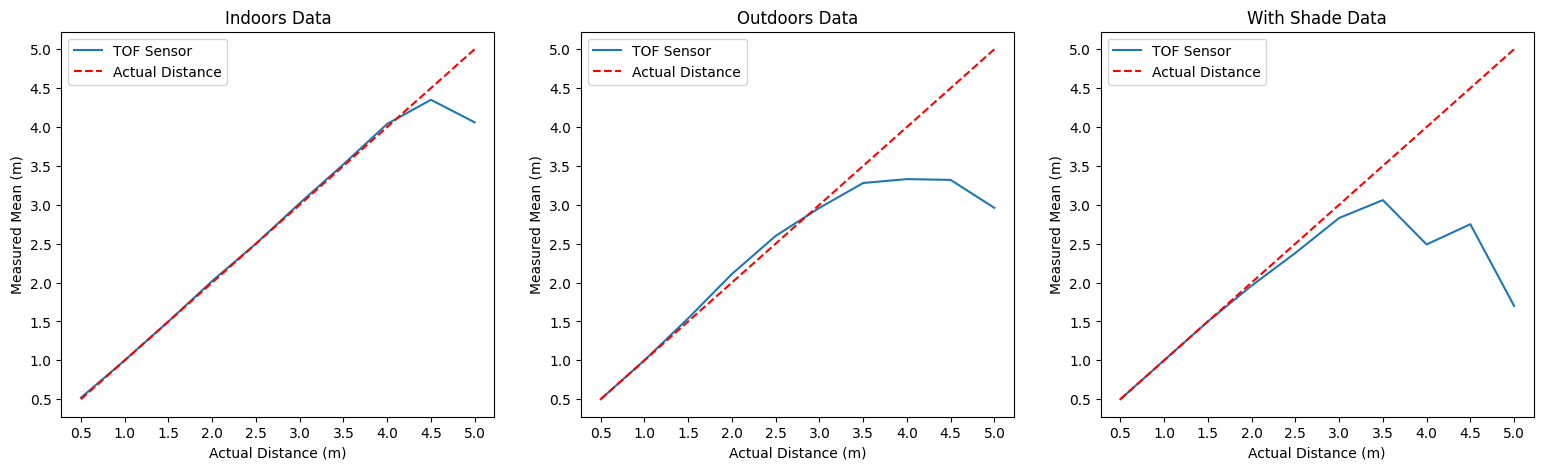

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(19, 5))
plot_mean_vs_actual_distance(axes[0], indoors_mean, title="Indoors Data")
plot_mean_vs_actual_distance(axes[1], outdoors_mean, title="Outdoors Data")
plot_mean_vs_actual_distance(axes[2], with_shade_mean, title="With Shade Data")
plt.show()

### Precision - Outdoors vs Indoors

- Next, we can evaluate the precision of the sensor by plotting a scatter plot of the raw data to see how closely measured points are to each other.
- We can see from the outdoors graph that the sensor is highly unreliable in bright daylight. From 1.5m onwards, the sensor outputs an increasingly large amount of spurious data. On the other hand, the indoors graph reveals that the sensor remains very precise indoors, and up until 3.5m, the amount of spurious data produced remains minimal.
- We also see the benefit of using the shade in an outdoors condition. Although the amount of spurious data from 3.0m onwards is still a lot, before that, the sensor performs with more precision compared to the outdoors data. This implies that using a shade might increase the reliability of the sensor at close distances.

In [19]:
def plot_scatter(ax: mpl.axes.Axes, data: list[list[float]], title="") -> None:
    """
    Plot a scatter plot of given data.

    Args:
        ax (mpl.axes.Axes): Matplotlib axes object.
        data (list[list[float]]): data[i] is the list of points measured at interval i.
        title (str): Title of the graph
    """
    for i, distance in enumerate(ACTUAL_DISTANCES):
        y = [distance] * len(data[i])
        ax.scatter(y, data[i], s=12, color="steelblue")

    ax.set_title(title)
    ax.set_xlabel("Measured Points (m)")
    ax.set_ylabel("Actual Distance (m)")
    ax.set_xticks(ACTUAL_DISTANCES)
    ax.set_yticks(ACTUAL_DISTANCES)

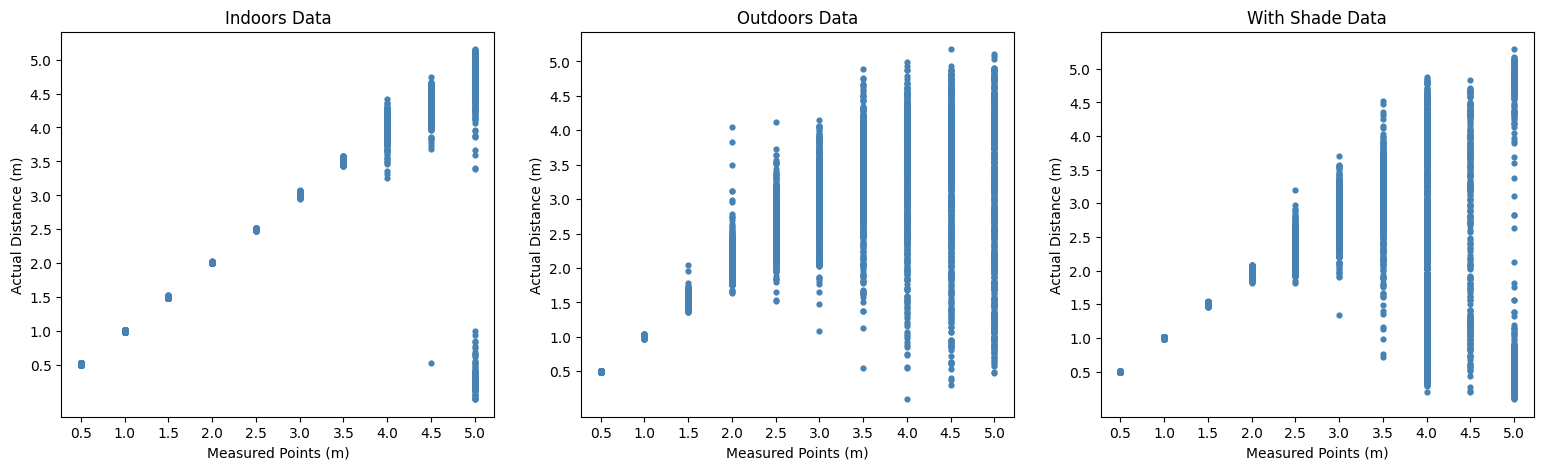

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(19, 5))
plot_scatter(axes[0], indoors_raw_data, title="Indoors Data")
plot_scatter(axes[1], outdoors_raw_data, title="Outdoors Data")
plot_scatter(axes[2], with_shade_raw_data, title="With Shade Data")

### Standard Deviation - Outdoors vs Indoors

- We can also plot the standard deviation of the points measured at each interval.
- Again, we can see that in under strong daylight, the sensor's precision is compromised by it's high standard deviation after interval 2.0m. In contrast, in an indoors environment, the standard deviation remains extremely low up until 4.5m onwards. This again shows how the sensor's reliability is strongly tied to the amount of natural light it is exposed to.
- At the same time, the with shade data again shows that the shade allows the sensor to be more precise at close intervals. Compared to the outdoors data, the standard deviation at each point is smaller up until 3.5m.

In [21]:
def plot_std_errorbar(ax: mpl.axes.Axes, data: list[float], std: list[float], title="") -> None:
    """
    Plot the standard deviation of the measured points against the actual distance.

    Args:
        ax (mpl.axes.Axes): Matplotlib axes object.
        data (list[float]): data[i] is the standard deviation of the points measured at interval i.
        title (str): Title of the graph.
    """
    ax.errorbar(ACTUAL_DISTANCES, data, yerr=std, fmt='o', linestyle='', ecolor="red", capsize=2)
    ax.set_title(title)
    ax.set_xlabel("Actual Distance (m)")
    ax.set_ylabel("Measured Mean (m)")
    ax.set_xticks(ACTUAL_DISTANCES)
    ax.set_yticks(ACTUAL_DISTANCES)

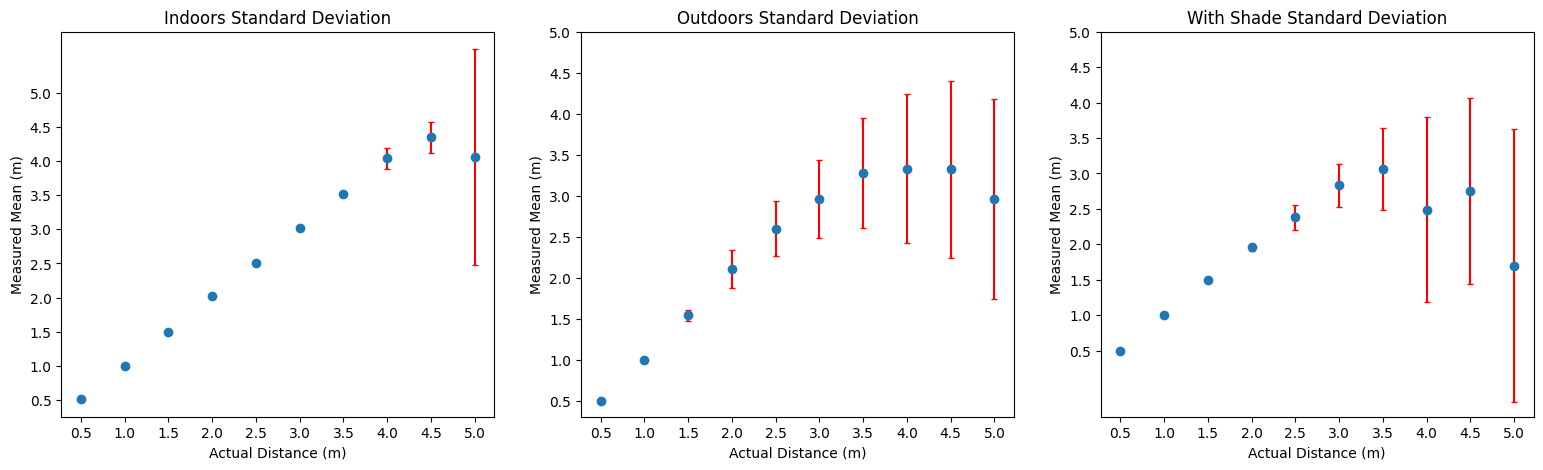

In [22]:
outdoors_std = get_standard_deviations(outdoors_raw_data)
indoors_std = get_standard_deviations(indoors_raw_data)
with_shade_std = get_standard_deviations(with_shade_raw_data)

fig, axes = plt.subplots(1, 3, figsize=(19, 5))
plot_std_errorbar(axes[0], indoors_mean, indoors_std, title="Indoors Standard Deviation")
plot_std_errorbar(axes[1], outdoors_mean, outdoors_std, title="Outdoors Standard Deviation")
plot_std_errorbar(axes[2], with_shade_mean, with_shade_std, title="With Shade Standard Deviation")

plt.show()

### Best Fit Line

#### Cleaning the Data

- Another way of showing the reliability of the sensor is by drawing a best fit curve through the average measurements at each interval. The closer the line is to a linear, $y = x$ curve, the more accurate it is.
- However, we the amount of spurious data that we have, our best fit curve will not be very accurate.
- Therefore, we can attempt to clean the preprocess the data before fitting it with a curve. One possibility is to remove all points greater than 1 standard deviation from the mean.
- Below we compare the graphs of the cleaned and raw data.

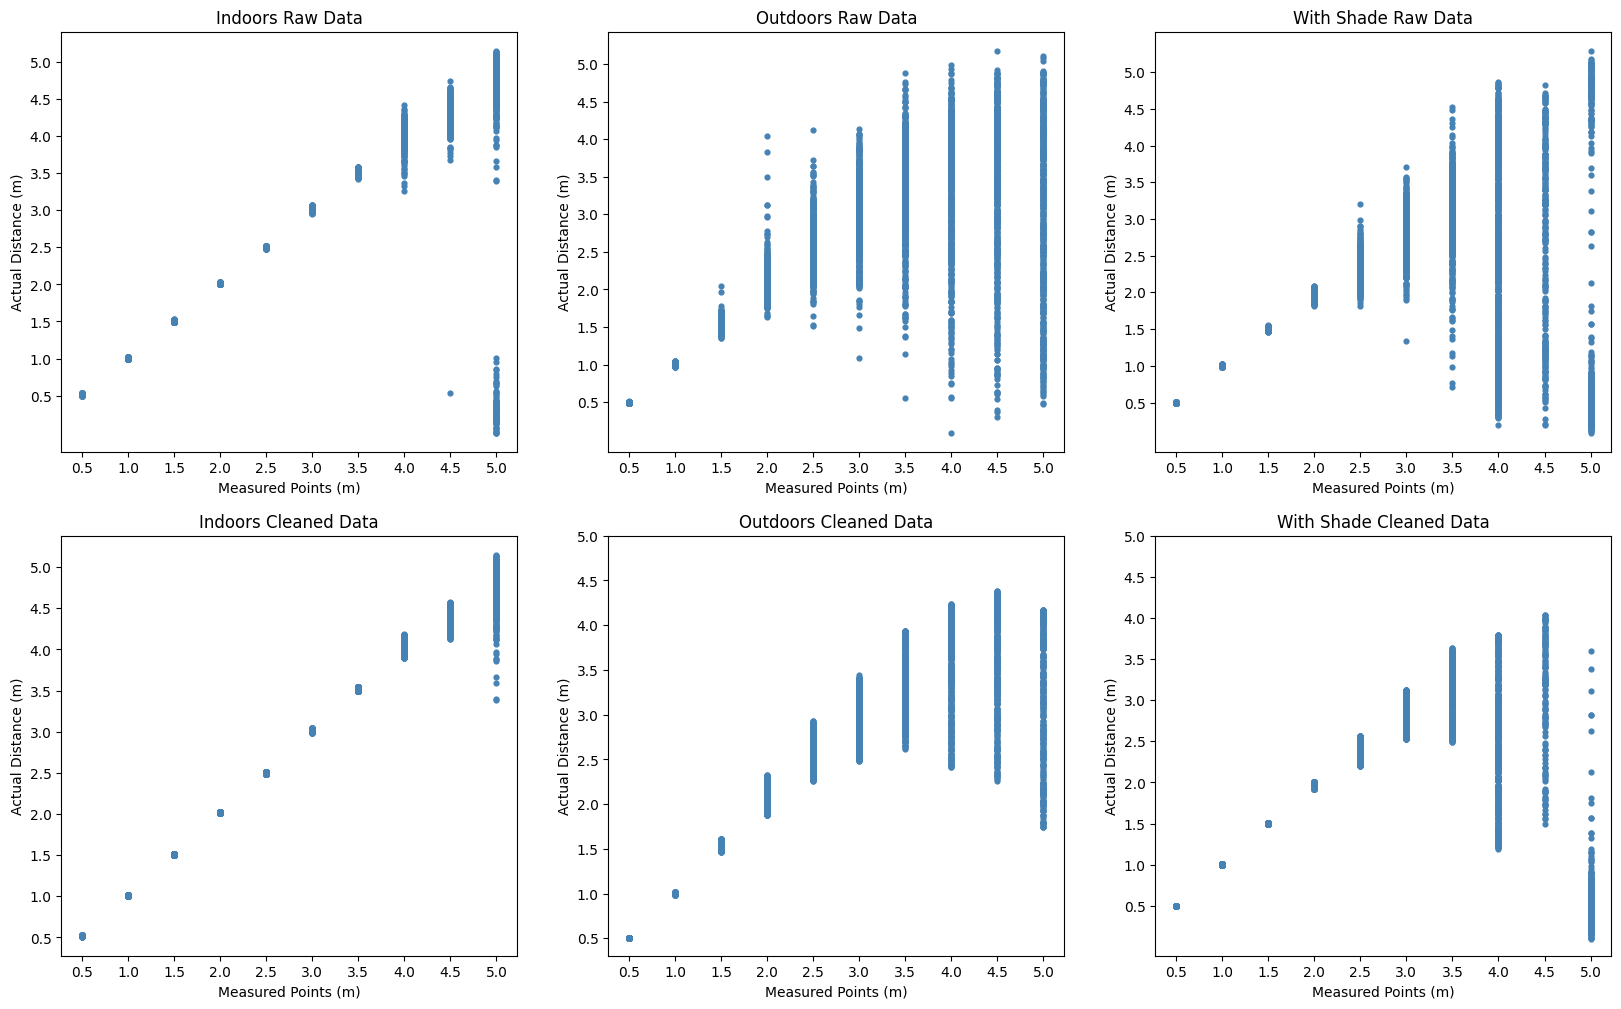

In [23]:
outdoors_cleaned = clean_tof_raw_data(outdoors_raw_data)
indoors_cleaned = clean_tof_raw_data(indoors_raw_data)
with_shade_cleaned = clean_tof_raw_data(with_shade_raw_data)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

plot_scatter(axes[0][0], indoors_raw_data, title="Indoors Raw Data")
plot_scatter(axes[0][1], outdoors_raw_data, title="Outdoors Raw Data")
plot_scatter(axes[0][2], with_shade_raw_data, title="With Shade Raw Data")

plot_scatter(axes[1][0], indoors_cleaned, title="Indoors Cleaned Data")
plot_scatter(axes[1][1], outdoors_cleaned, title="Outdoors Cleaned Data")
plot_scatter(axes[1][2], with_shade_cleaned, title="With Shade Cleaned Data")

plt.show()

#### Comparing Best Fit Lines

- From the graphs below, we can see that cleaning the data has some minor improvements to the reliability of the sensor.
- For the outdoors data, the improvement was slight with a slope of $0.62x$ to $0.67x$.
- However, the improvement was a lot more significant for the indoors data with a slope from $0.88x$ to $0.96x$, where it became almost similar to the $y = x$ line.
- In contrast, for the data with the shade, cleaning the data reduced its reliability with a slope from $0.39x$ to $0.29x$. This is likely because of the large amount of spurious points at the higher distance intervals which allowed the data to average out more consistently. And once they were removed, the average was no longer as accurate.
- Therefore, my first priority should be in removing the errors caused by over exposure to natural light, and I could then focus on cleaning the data as a secondary method to enhance the reliability of the data collected.

In [24]:
def plot_best_fit(ax: mpl.axes.Axes, data: list[list[float]], title="") -> None:
    """
    Helper function to draw the best fit line for TOF measurements.

    Args:
        ax (mpl.axes.Axes): Matplotlib Axes object.
        data (list[list[float]]): data[i] is the distances measured at the ith interval.
    """
    x, y = flatten(data)
    draw_line(ax, x, y)
    ax.plot(ACTUAL_DISTANCES, ACTUAL_DISTANCES, color="red", linestyle="--", label='y = x')
    plot_scatter(ax, data, title=title)
    ax.grid(color='#Dedede', linestyle='--', linewidth=1)
    ax.legend()


def flatten(data: list[list[float]]) -> tuple[list[float]]:
    """
    Flatten the TOF data so we can use it to draw a best fit line.

    Args:
        data (list[list[float]]): data[i] is the distances measured at the ith interval.

    Returns:
        tuple[list[float]]: Return x, y which are lists representing x and y points.
    """
    x = []
    y = []

    for i, distance_interval in enumerate(ACTUAL_DISTANCES):
        y.extend(data[i])
        x.extend([distance_interval] * len(data[i]))
    
    return x, y


def draw_line(ax: mpl.axes.Axes, x: list[float], y: list[float]) -> None:
    """
    Given a set of x and y coordinates, plot a best fit line on the axes.

    Args:
        ax (mpl.axes.Axes): Matplotlib Axes object.
        x (list[float]): x points.
        y (list[float]): y points.
    """
    m, b = np.polyfit(x, y, deg=1)
    best_fit = np.poly1d((m, b))
    ax.plot(x, best_fit(x), color="green", linestyle='--', label=f'y = {m:.2f}x + {b:.2f}')

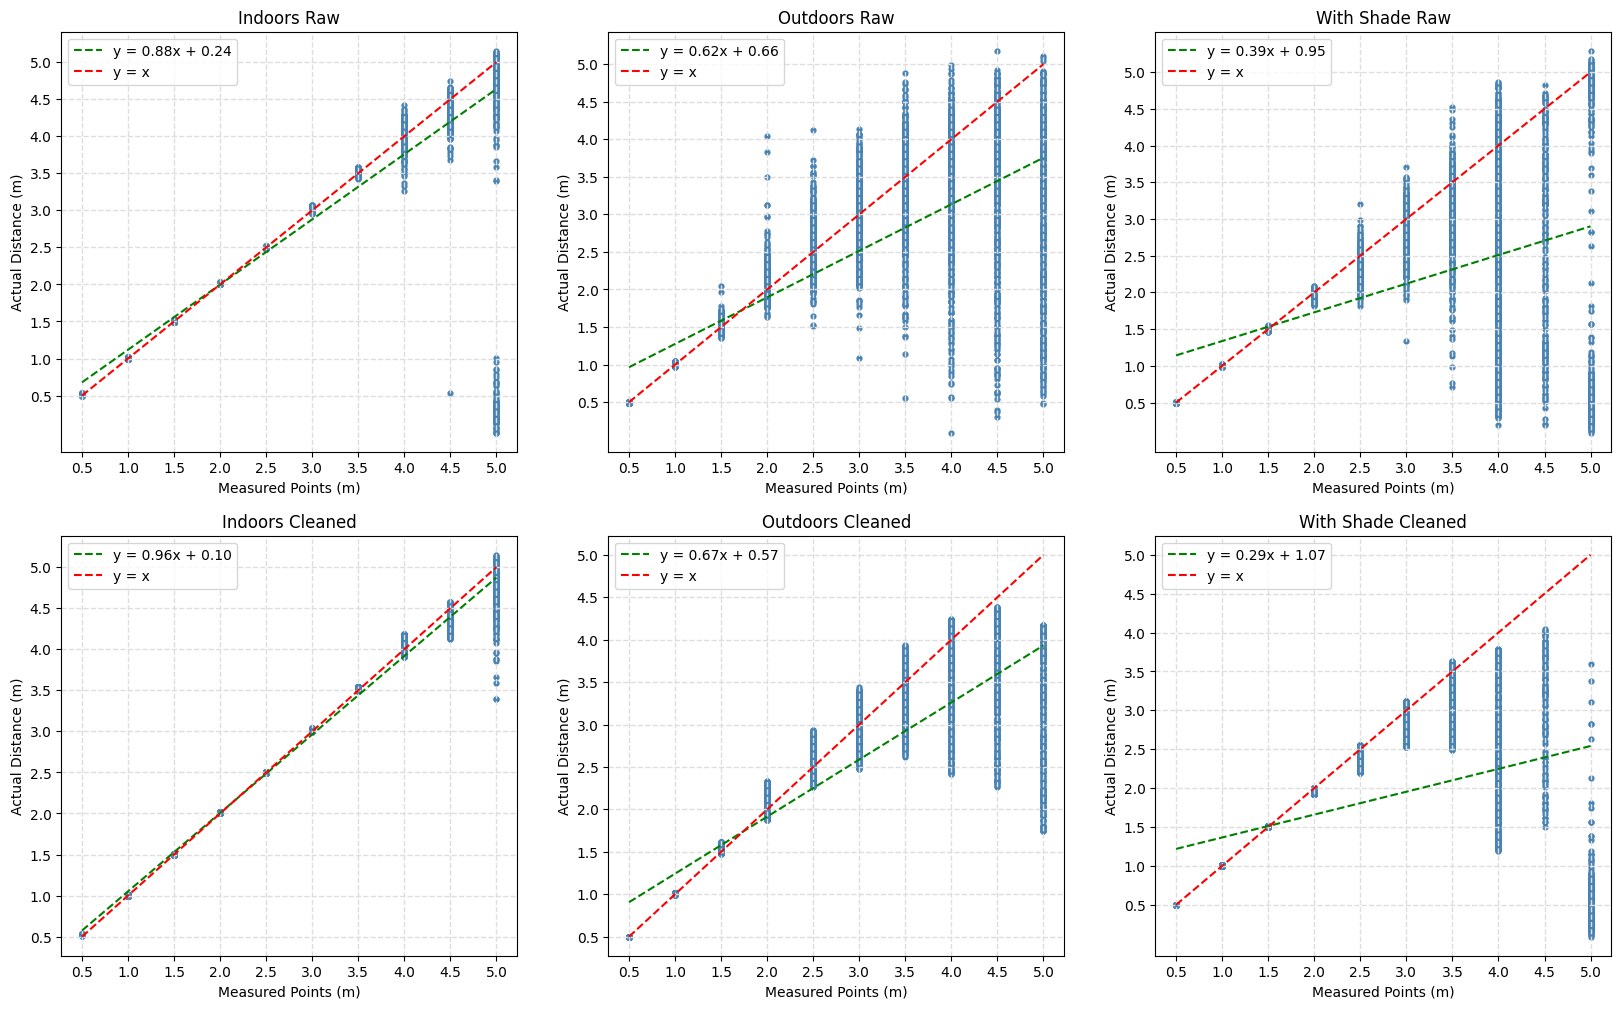

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

plot_best_fit(axes[0][0], indoors_raw_data, "Indoors Raw")
plot_best_fit(axes[0][1], outdoors_raw_data, "Outdoors Raw")
plot_best_fit(axes[0][2], with_shade_raw_data, "With Shade Raw")

plot_best_fit(axes[1][0], indoors_cleaned, title="Indoors Cleaned")
plot_best_fit(axes[1][1], outdoors_cleaned, title="Outdoors Cleaned")
plot_best_fit(axes[1][2], with_shade_cleaned, title="With Shade Cleaned")

plt.show()

## Conclusion

In conclusion, from these simple stationary tests, I was able to determine that the TOF sensor was in working condition and could measure distance. While it was very accurate in measuring distances up to 4m in an indoor environment, it performed poorly in an outdoor environment when exposed to natural light, and generated a lot of suprious data. To attempt to remedy this, I 3D-printed a case to act as a shield against the sunlight and tested it again. This was only effective at increasing the sensor's reliability at closer distances (i.e. 2m and less) and saw less spurious points being generated. However, at further distances, the casing impeded the sensor's measuring capabilities, as even a slight tilt in the angle could see the casing interfere with the sensor. Therefore, in practice I would use the sensor with the case. The aim of the project is to measure vehicles which closely overtake the cyclist (i.e. less than 2m), and for such distances the casing would be a good way to enhance the sensor's accuracy and precision.